For more details on the project, check my [Promo Optimization Case Study](https://github.com/srk96/mbc-promo-optimization.git) on GitHub.

## Introduction 

### MBC Group Promo Optimization Case Study

The primary goal of this analysis is to optimize the placement of promotional content across MBC Group's TV grid. This will be achieved by applying data science techniques to prioritize promo placements based on viewership reach, promo priority, and demographic targeting, ensuring strategic alignment with business objectives.

### Background
MBC Group is a prominent media company in the Middle East, operating multiple TV channels and digital platforms. Efficient promo placement can significantly enhance viewer engagement and advertising revenue, making it crucial for operational success.

## Setup 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enhance the default display settings for plots and dataframes
%matplotlib inline
sns.set(style="whitegrid")  # for nicer plots
pd.set_option('display.max_columns', None)  # show all columns in dataframes

## Load Data 

In [2]:
# Load the datasets
assignment_data = pd.read_csv(r'C:\Users\steph\Desktop\CaseStudy\assignment_dataset.csv')
promos_data = pd.read_csv(r'C:\Users\steph\Desktop\CaseStudy\promos.csv')

# Display the first few rows of each dataset to inspect them
print("Assignment Dataset Preview:")
display(assignment_data.head())
print("\nPromos Dataset Preview:")
display(promos_data.head())

Assignment Dataset Preview:


,timestamp,end_timestamp,Slot,Segment No.,Total Airtime (seconds),target_audience,reach_avg
0,30/01/2024 6:00,30/01/2024 6:16,1,1,240,female,584.875000
1,30/01/2024 6:16,30/01/2024 6:25,1,2,240,female,610.777778
2,30/01/2024 6:25,30/01/2024 6:34,1,3,240,female,614.666667
3,30/01/2024 7:00,30/01/2024 7:15,2,1,360,female,617.200000
4,30/01/2024 7:15,30/01/2024 7:21,2,2,360,female,684.833333



Promos Dataset Preview:


,Campaign,Priority,HN,Notes,Target-Audience(Male/Female/Kids),Promo Duration Seconds
0,1,M,DIG-08357,MBC1,Female/Male,102
1,2,H,DIG-08358,MBC1,Female,80
2,3,H,DIG-08368,MBC1,Female/Male,60
3,4,H,DIG-08374,MBC1,Female/Male,55
4,5,H,DIG-08376,MBC1,Female/Male,35


## Data Exploration

In [3]:
# Basic information and statistics for understanding the datasets better
print("Assignment Data Info:")
print(assignment_data.info())
print("\nPromos Data Info:")
print(promos_data.info())

# Summary statistics for numerical features
print("\nAssignment Data Description:")
print(assignment_data.describe())
print("\nPromos Data Description:")
print(promos_data.describe())

# Check for missing values
print("\nMissing Values in Assignment Data:")
print(assignment_data.isnull().sum())
print("\nMissing Values in Promos Data:")
print(promos_data.isnull().sum())

Assignment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                66 non-null     object 
 1   end_timestamp            66 non-null     object 
 2   Slot                     66 non-null     int64  
 3   Segment No.              66 non-null     int64  
 4   Total Airtime (seconds)  66 non-null     int64  
 5   target_audience          66 non-null     object 
 6   reach_avg                66 non-null     float64
dtypes: float64(1), int64(3), object(3)
memory usage: 3.7+ KB
None

Promos Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Campaign                           7 non-null      int64 
 1   Priority  

## Data Preprocessing 

### Convert Data Types 

In [4]:
# Converting 'timestamp' and 'end_timestamp' to datetime format
assignment_data['timestamp'] = pd.to_datetime(assignment_data['timestamp'])
assignment_data['end_timestamp'] = pd.to_datetime(assignment_data['end_timestamp'])

The `timestamp` fields are converted to datetime objects to enable precise time-based calculations and to extract additional time-related features, which are crucial for analyzing trends over different times of the day or week.

### Feature Engineering 

#### Time Features 

In [5]:
# Extract day of the week, hour, and duration from timestamps
assignment_data['day_of_week'] = assignment_data['timestamp'].dt.day_name()
assignment_data['start_hour'] = assignment_data['timestamp'].dt.hour
assignment_data['duration_seconds'] = (assignment_data['end_timestamp'] - assignment_data['timestamp']).dt.total_seconds()

# Display the first few rows to verify new columns
display(assignment_data.head())

,timestamp,end_timestamp,Slot,Segment No.,Total Airtime (seconds),target_audience,reach_avg,day_of_week,start_hour,duration_seconds
0,2024-01-30 06:00:00,2024-01-30 06:16:00,1,1,240,female,584.875000,Tuesday,6,960.0
1,2024-01-30 06:16:00,2024-01-30 06:25:00,1,2,240,female,610.777778,Tuesday,6,540.0
2,2024-01-30 06:25:00,2024-01-30 06:34:00,1,3,240,female,614.666667,Tuesday,6,540.0
3,2024-01-30 07:00:00,2024-01-30 07:15:00,2,1,360,female,617.200000,Tuesday,7,900.0
4,2024-01-30 07:15:00,2024-01-30 07:21:00,2,2,360,female,684.833333,Tuesday,7,360.0


#### Time-Based Features Engineering (useful for future additional insights)

#### Feature 1: `day_of_week`
- **Description**: This feature extracts the day of the week from the `timestamp` column (e.g., Monday, Tuesday).
- **Purpose**: To explore if promo performance varies depending on the day of the week.
- **Rationale**: Viewer habits can vary significantly between weekdays and weekends, and understanding this pattern can help optimize promo placements.

#### Feature 2: `start_hour`
- **Description**: Extracts the starting hour from the `timestamp` column.
- **Purpose**: To analyze the impact of the starting hour on viewer engagement.
- **Rationale**: Promos aired during prime hours (e.g., 8 PM - 10 PM) are likely to have higher reach compared to non-prime hours. Understanding this pattern helps prioritize promo slots.

#### Feature 3: `duration_seconds`
- **Description**: Calculates the duration in seconds of each TV segment based on the `timestamp` and `end_timestamp` columns.
- **Purpose**: To assess if the segment duration has any correlation with the average viewer reach.
- **Rationale**: Longer segments might retain viewers better due to continuity, but shorter segments can offer quicker content consumption. Understanding this can inform better segmentation strategies.

#### Visualizations of Time-Based Features 

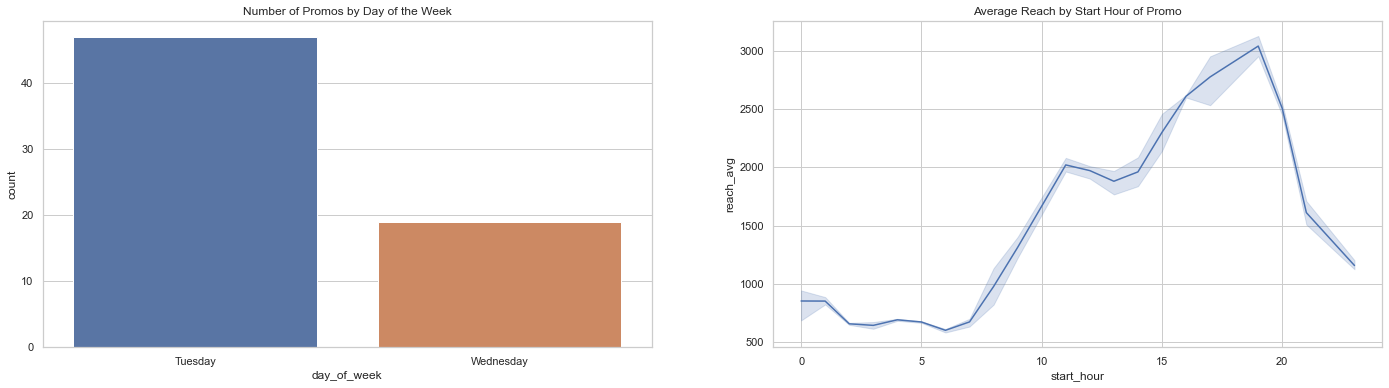

In [7]:
# Set up the matplotlib figure
plt.figure(figsize=(24, 6))  # Increase the total size of the figure

# Plot 1: Countplot of days of the week
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
sns.countplot(x='day_of_week', data=assignment_data)
plt.title('Number of Promos by Day of the Week')

# Plot 2: Line plot of reach average by start hour
plt.subplot(1, 2, 2)
sns.lineplot(x='start_hour', y='reach_avg', data=assignment_data)
plt.title('Average Reach by Start Hour of Promo')

# Display the figure with both plots
plt.show()

#### Insights from Time-Based Features

- Day of the Week Patterns:
Analyze which days of the week have the highest and lowest reach to prioritize promo slots accordingly.

- Hourly Patterns:
Identify the hours that yield the highest reach and optimize promo placement accordingly.

- Duration Impact:
Assess if longer or shorter segments correlate with higher viewer engagement.

#### Target Audience Simplification (useful for Possible Future Predictive Modeling)

In [20]:
# Display unique target audience categories
unique_categories = promos_data['Target-Audience(Male/Female/Kids)'].unique()
print("Unique Target Audience Categories:", unique_categories)

unique_categories = assignment_data['target_audience'].unique()
print("Unique Target Audience Categories:", unique_categories)

Unique Target Audience Categories: ['Female/Male' 'Female']
Unique Target Audience Categories: ['female' 'female/male']


In [22]:
# Creating a mapping of target audience categories to numerical values
target_audience_mapping = {
    'Female': 0, 
    'Female/Male': 1
}

target_audience_mapping_other = {
    'female': 0, 
    'female/male': 1
}

# Encoding target audience for easier analysis
promos_data['target_audience_encoded'] = promos_data['Target-Audience(Male/Female/Kids)'].map(target_audience_mapping)
assignment_data['target_audience_encoded'] = assignment_data['target_audience'].map(target_audience_mapping_other)

# Display the first few rows to verify the new column
display(promos_data.head())
display(assignment_data.head())

,Campaign,Priority,HN,Notes,Target-Audience(Male/Female/Kids),Promo Duration Seconds,target_audience_encoded
0,1,M,DIG-08357,MBC1,Female/Male,102,1
1,2,H,DIG-08358,MBC1,Female,80,0
2,3,H,DIG-08368,MBC1,Female/Male,60,1
3,4,H,DIG-08374,MBC1,Female/Male,55,1
4,5,H,DIG-08376,MBC1,Female/Male,35,1


,timestamp,end_timestamp,Slot,Segment No.,Total Airtime (seconds),target_audience,reach_avg,day_of_week,start_hour,duration_seconds,target_audience_encoded
0,2024-01-30 06:00:00,2024-01-30 06:16:00,1,1,240,female,584.875000,Tuesday,6,960.0,0
1,2024-01-30 06:16:00,2024-01-30 06:25:00,1,2,240,female,610.777778,Tuesday,6,540.0,0
2,2024-01-30 06:25:00,2024-01-30 06:34:00,1,3,240,female,614.666667,Tuesday,6,540.0,0
3,2024-01-30 07:00:00,2024-01-30 07:15:00,2,1,360,female,617.200000,Tuesday,7,900.0,0
4,2024-01-30 07:15:00,2024-01-30 07:21:00,2,2,360,female,684.833333,Tuesday,7,360.0,0


#### Target Audience Feature Engineering

#### Feature 1: `target_audience_encoded`
- **Description**: Encodes the target audience information into numerical values for easier analysis.
- **Purpose**: To match the promos with the appropriate TV segments based on audience compatibility.
- **Rationale**: Different promos target different demographics, so encoding this information facilitates audience-based filtering and prioritization.

#### Insights from Target Audience Feature

Audience Compatibility:

- Identify which TV segments are suitable for each promo based on the target audience.
- Optimize placements by ensuring high-priority promos target the most relevant audience segments.

#### Visualizations of Target Audience Features 

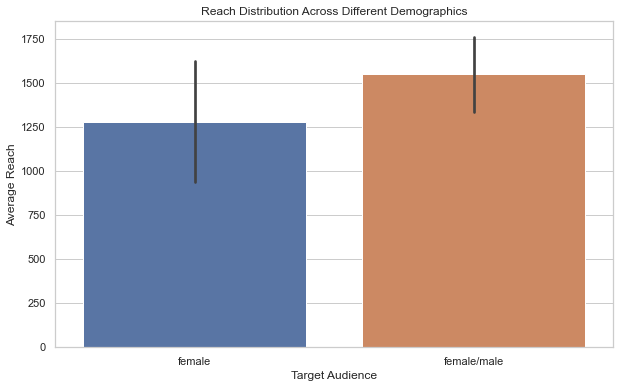

In [109]:
# Visualization 3: Reach Distribution Across Different Demographics
plt.figure(figsize=(10, 6))
sns.barplot(x='target_audience', y='reach_avg', data=assignment_data)
plt.title('Reach Distribution Across Different Demographics')
plt.xlabel('Target Audience')
plt.ylabel('Average Reach')
plt.show()

### Data Consistency Checks

In [14]:
# Check unique values in categorical columns to ensure consistency
print("Unique values in 'target_audience':", assignment_data['target_audience'].unique())
print("Unique values in 'Priority':", promos_data['Priority'].unique())

Unique values in 'target_audience': ['female' 'female/male']
Unique values in 'Priority': ['M' 'H' 'L']


Ensuring consistency in categorical data and encoding complex categories into numerical values simplifies the analysis and assists in building more robust models.

## Optimization Problem 

## Step 1: Define the Optimization Model

Goals and Constraints Recap

- Priority Handling: Ensure high-priority promos have a higher overall reach than medium, and medium more than low.
- Airtime Constraints: The combined duration of all promos in a slot must not exceed the available airtime.
- Demographic Matching: Promos must be placed in slots that match their target demographic requirements.

Optimization Approaches

- Greedy Algorithm/Heuristic algorithm -> A greedy algorithm makes the locally optimal choice at each stage with the hope of finding the global optimum -> For our promo optimization problem, this could involve sequentially placing the highest priority promos in the slots that offer the highest potential reach while respecting the airtime and demographic constraints.

## Step 2: Implement Greedy/Heuristic Algorithm

### Initial Promo-Slot-Segment Matching Test

In [111]:
def test_optimization(assignment_data, promos_data):
    """
    A simple test function to demonstrate initial matching between promos and slots' segments
    without considering any specific optimization constraints.
    
    Args:
    - assignment_data (DataFrame): The dataframe containing slot and segment details.
    - promos_data (DataFrame): The dataframe containing promo details.

    Returns:
    - tuple: A message indicating a match was found along with the promo, slot, and segment IDs, or a message that no matches were found.
    """
    # Iterate over each promo in the promos dataset
    for _, promo in promos_data.iterrows():
        # Iterate over each slot and its segments in the assignment dataset
        for i, slot in assignment_data.iterrows():
            # Print the current promo and slot-segment being tested for matching
            print(f"Testing Promo {promo['HN']} to Slot {slot['Slot']} Segment {slot['Segment No.']}")
            # Temporarily ignore actual conditions for a basic match check
            if True:  # This condition should be replaced with actual matching logic
                return "Basic match found", promo['HN'], slot['Slot'], slot['Segment No.']
    # Return this if no matches are found after all iterations
    return "No matches found"

# Test this simple matching function
print(test_optimization(assignment_data, promos_data))

Testing Promo DIG-08362 to Slot 1 Segment 1
('Basic match found', 'DIG-08362', 1, 1)


This function, `test_optimization`, is designed to perform a simple initial test of matching promos to slots. It iterates through each promo and slot pair and checks for a basic match without applying any specific constraints or optimization logic.

This approach helps in quickly verifying the basic functionality of the data processing and the iteration mechanism. It also sets the stage for introducing more complex constraints such as airtime limits, demographic matching, and priority handling in subsequent optimization steps.

### Function Optimization Enhancement

#### Adding Hard Constraint 1: Audience Demographics

In [138]:
def matches_demographic(promo_audience, slot_audience):
    """
    Checks if the promo's audience matches the slot's audience. Allows 'Female/Male' audience promos to be placed anywhere,
    while other promos must match the slot audience exactly.

    Args:
        promo_audience (str): Audience type of the promo ('Female/Male', 'Female', 'Male')
        slot_audience (str): Audience type of the slot ('Female', 'Male')

    Returns:
        bool: True if the promo can be placed in the slot, False otherwise.
    """
    # Allow 'Female/Male' promos to be placed in any slot.
    if promo_audience == 1:
        return True
    # Require that the promo audience matches the slot audience exactly for other types.
    else:
        return promo_audience == slot_audience

def demographic_optimization(assignment_data, promos_data):
    optimized_schedule = []
    
    # Iterate over each slot
    for _, slot in assignment_data.iterrows():
        slot_audience = slot['target_audience_encoded']

        # Try to place each promo in the current slot
        for _, promo in promos_data.iterrows():
            promo_audience = promo['target_audience_encoded']
            if matches_demographic(promo_audience, slot_audience):
                optimized_schedule.append({
                    'Promo Code': promo['HN'],
                    'Slot': slot['Slot'],
                    'Segment': slot['Segment No.'],
                    'Promo Duration': promo['Promo Duration Seconds'],
                    'Promo Audience': promo_audience,
                    'Slot Audience': slot_audience
                })

    return pd.DataFrame(optimized_schedule)

# Execute the optimization function and print the resulting DataFrame
optimized_schedule_df = demographic_optimization(assignment_data, promos_data)
print(optimized_schedule_df)

    Promo Code  Slot  Segment  Promo Duration  Promo Audience  Slot Audience
0    DIG-08362     1        1              40               0              0
1    DIG-08357     1        1             102               1              0
2    DIG-08358     1        1              80               0              0
3    DIG-08368     1        1              60               1              0
4    DIG-08374     1        1              55               1              0
..         ...   ...      ...             ...             ...            ...
365  DIG-08358    26        3              80               0              0
366  DIG-08368    26        3              60               1              0
367  DIG-08374    26        3              55               1              0
368  DIG-08376    26        3              35               1              0
369  DIG-08378    26        3              35               1              0

[370 rows x 6 columns]


#### Demographic Optimization of Promo Placements

The `demographic_optimization` function orchestrates the allocation of promotional content to TV schedule slots based strictly on demographic compatibility. It leverages a helper function, `matches_demographic`, to validate that the target audience of a promo aligns with the target audience of a slot.

#### Function Logic:
- **Universal and Specific Demographic Matching**: The function checks each promo against every slot to find a match based on the audience. Promos targeting "Female/Male" are universally applicable and can be placed in any slot, which maximizes their placement flexibility. In contrast, promos specifically targeting "Female" or "Male" are only placed in slots that match these demographics, adhering strictly to the audience targeting requirements.


- **Structured Output**: The function compiles a list of placement details, including each promo's code, the slot and segment it was placed in, the duration of the promo, and the target audiences. This list is then converted into a DataFrame, providing a clear and structured view of the optimized schedule.


- **Validation and Transparency**: By including both the promo and slot audiences in the output, this approach allows for easy validation and review of the demographic matching strategy, ensuring that each placement is appropriate and effective.

This method ensures that the promotional strategy is both effective in reaching the intended audiences and compliant with advertising standards, thereby enhancing the overall impact of the advertising campaign.

In [140]:
# Group by promo code and count occurrences to ensure functionality of above function
promo_grouped = optimized_schedule_df.groupby('Promo Code').count()['Slot']  # Counting occurrences based on the 'Slot' column

# Get the count for a specific promo code -> containing audience Female/Male -> can be allocated in ANY slot
specific_promo_count = promo_grouped.get('DIG-08374', 0)  # Default to 0 if not found

print(f"The promo code 'DIG-08362' was placed {specific_promo_count} times.")

The promo code 'DIG-08362' was placed 66 times.


In [141]:
# Group by promo code and count occurrences to ensure functionality of above function
promo_grouped = optimized_schedule_df.groupby('Promo Code').count()['Slot']  # Counting occurrences based on the 'Slot' column

# Get the count for a specific promo code -> containing audience Female -> should only be allocated with female slots
specific_promo_count = promo_grouped.get('DIG-08362', 0)  # Default to 0 if not found

print(f"The promo code 'DIG-08362' was placed {specific_promo_count} times.")

The promo code 'DIG-08362' was placed 20 times.


In [142]:
# Run the above optimization function to further ensure that the above function is functioning
optimized_schedule_df = demographic_optimization(assignment_data, promos_data)

# Check if the "Female/Male" promo is placed in a "Female" slot
if not optimized_schedule_df.empty:
    result = optimized_schedule_df[(optimized_schedule_df['Promo Audience'] == 1) & 
                                   (optimized_schedule_df['Slot Audience'] == 0)]
    if not result.empty:
        print("Test Passed: 'Female/Male' promo was successfully placed in a 'Female' slot.")
        print(result)
    else:
        print("Test Failed: 'Female/Male' promo was not placed in a 'Female' slot.")
else:
    print("No placements were made.")

# Execute the test function
test_universal_matching()

Test Passed: 'Female/Male' promo was successfully placed in a 'Female' slot.
    Promo Code  Slot  Segment  Promo Duration  Promo Audience  Slot Audience
1    DIG-08357     1        1             102               1              0
3    DIG-08368     1        1              60               1              0
4    DIG-08374     1        1              55               1              0
5    DIG-08376     1        1              35               1              0
6    DIG-08378     1        1              35               1              0
..         ...   ...      ...             ...             ...            ...
364  DIG-08357    26        3             102               1              0
366  DIG-08368    26        3              60               1              0
367  DIG-08374    26        3              55               1              0
368  DIG-08376    26        3              35               1              0
369  DIG-08378    26        3              35               1              0

#### Adding Hard Constraint 2: Priority Handling

In [143]:
def matches_demographic(promo_audience, slot_audience):
    """
    Checks if the promo's audience matches the slot's audience. Allows 'Female/Male' audience promos to be placed anywhere,
    while other promos must match the slot audience exactly.

    Args:
        promo_audience (str): Audience type of the promo ('Female/Male', 'Female', 'Male')
        slot_audience (str): Audience type of the slot ('Female', 'Male')

    Returns:
        bool: True if the promo can be placed in the slot, False otherwise.
    """
    # Allow 'Female/Male' promos to be placed in any slot.
    if promo_audience == 1:
        return True
    # Require that the promo audience matches the slot audience exactly for other types.
    else:
        return promo_audience == slot_audience

def demographic_optimization(assignment_data, promos_data):
    """
    Optimizes promo placements based on demographic compatibility and calculates the reach,
    ensuring that priority requirements are met.

    Args:
        assignment_data (DataFrame): Contains slot details including average reach per minute.
        promos_data (DataFrame): Contains promo details including duration and priority.

    Returns:
        tuple: A DataFrame of the optimized schedule and a dictionary of reach by priority.
    """
    optimized_schedule = []
    for _, promo in promos_data.iterrows():
        for _, slot in assignment_data.iterrows():
            if matches_demographic(promo['target_audience_encoded'], slot['target_audience_encoded']):
                # Calculate reach assuming reach per minute
                reach = slot['reach_avg'] * (promo['Promo Duration Seconds'] / 60)
                optimized_schedule.append({
                    'Promo Code': promo['HN'],
                    'Priority': promo['Priority'],
                    'Slot': slot['Slot'],
                    'Segment': slot['Segment No.'],
                    'Promo Duration': promo['Promo Duration Seconds'],
                    'Reach': reach
                })

    df_placements = pd.DataFrame(optimized_schedule)

    # Aggregate reach by priority and check if they meet the business rules
    if not df_placements.empty:
        reach_by_priority = df_placements.groupby('Priority')['Reach'].sum()
        print("Total reach by priority:", reach_by_priority)
        if not (reach_by_priority.get('H', 0) > reach_by_priority.get('M', 0) > reach_by_priority.get('L', 0)):
            print("Priority reach conditions not met, adjustments may be needed.")
    else:
        print("No placements were made.")
        reach_by_priority = {}

    return df_placements, reach_by_priority

# Execute the optimization function and print the resulting DataFrame
optimized_schedule_df, reach_by_priority = demographic_optimization(assignment_data, promos_data)
print(optimized_schedule_df)

Total reach by priority: Priority
H    332703.529287
L     17054.262128
M    164630.759531
Name: Reach, dtype: float64
    Promo Code Priority  Slot  Segment  Promo Duration       Reach
0    DIG-08362        L     1        1              40  389.916667
1    DIG-08362        L     1        2              40  407.185185
2    DIG-08362        L     1        3              40  409.777778
3    DIG-08362        L     2        1              40  411.466667
4    DIG-08362        L     2        2              40  456.555556
..         ...      ...   ...      ...             ...         ...
365  DIG-08378        H    25        1              35  409.370370
366  DIG-08378        H    25        2              35  399.648148
367  DIG-08378        H    26        1              35  389.583333
368  DIG-08378        H    26        2              35  394.770833
369  DIG-08378        H    26        3              35  396.739583

[370 rows x 6 columns]


#### Optimization of Promotional Placements by Demographic Matching and Priority

This function `demographic_optimization` is designed to allocate promotional content to TV slots based on the compatibility of their target audiences and calculate the effectiveness of these placements in terms of reach. The function also ensures that the placements adhere to priority constraints, where high-priority promos must achieve a higher reach than medium, and medium must achieve a higher reach than low.

#### Function Workflow:
1. **Demographic Matching**: Each promo is checked against each slot to see if its target audience matches the slot's audience, with special handling for promos targeted to both genders.
2. **Reach Calculation**: For promos that match a slot demographically, the reach is calculated based on the slot's average viewership and the duration of the promo.
3. **Aggregation and Validation**: The total reach is then aggregated by promo priority. The function verifies if these aggregated values meet the defined business rules that higher priority promos should always have higher reach.
4. **Output**: The function returns a detailed DataFrame of all valid placements along with their calculated reach, and a summary of reach by priority.

#### Importance:
This approach not only ensures the efficient placement of ads but also enforces strategic business rules that aim to maximize the impact of higher priority promotions, aligning marketing efforts with business objectives.

#### Adding Hard Constraint 3: Airtime Constraint

In [147]:
def matches_demographic(promo_audience, slot_audience):
    """
    Checks if the promo's audience matches the slot's audience. Allows 'Female/Male' audience promos to be placed anywhere,
    while other promos must match the slot audience exactly.

    Args:
        promo_audience (str): Audience type of the promo ('Female/Male', 'Female', 'Male')
        slot_audience (str): Audience type of the slot ('Female', 'Male')

    Returns:
        bool: True if the promo can be placed in the slot, False otherwise.
    """
    # Allow 'Female/Male' promos to be placed in any slot.
    if promo_audience == 1:
        return True
    # Require that the promo audience matches the slot audience exactly for other types.
    else:
        return promo_audience == slot_audience

def demographic_optimization(assignment_data, promos_data):
    optimized_schedule = []
    unplaced_promos = []  # List to keep track of unplaced promos
    # Initialize remaining airtime for each slot
    remaining_airtime = assignment_data.set_index('Slot')['Total Airtime (seconds)'].to_dict()

    for _, promo in promos_data.iterrows():
        placed=False
        for _, slot in assignment_data.iterrows():
            if matches_demographic(promo['target_audience_encoded'], slot['target_audience_encoded']):
                # Check if there's enough airtime left in the slot for the promo
                if remaining_airtime[slot['Slot']] >= promo['Promo Duration Seconds']:
                    reach = slot['reach_avg'] * (promo['Promo Duration Seconds'] / 60)  # Calculate reach assuming reach per minute
                    optimized_schedule.append({
                        'Promo Code': promo['HN'],
                        'Priority': promo['Priority'],
                        'Slot': slot['Slot'],
                        'Segment': slot['Segment No.'],
                        'Promo Duration': promo['Promo Duration Seconds'],
                        'Reach': reach
                    })
                    # Deduct the promo duration from the remaining airtime for the slot
                    remaining_airtime[slot['Slot']] -= promo['Promo Duration Seconds']
                    placed=True
                    
        if not placed:
            unplaced_promos.append(promo['HN'])  # Add promo code to unplaced list

    # Convert placements to DataFrame
    df_placements = pd.DataFrame(optimized_schedule)

    # Check and print reach by priority
    if not df_placements.empty:
        reach_by_priority = df_placements.groupby('Priority')['Reach'].sum()
        print("Total reach by priority:", reach_by_priority)
    else:
        print("No placements were made.")
        reach_by_priority = {}

    # Ensure business rules for reach by priority (optional additional checks)
    if not (reach_by_priority.get('H', 0) > reach_by_priority.get('M', 0) > reach_by_priority.get('L', 0)):
        print("Priority reach conditions not met, adjustments may be needed.")

    return df_placements, reach_by_priority, unplaced_promos

# Execute the optimization function and print the resulting DataFrame
optimized_schedule_df, reach_by_priority, unplaced_promos = demographic_optimization(assignment_data, promos_data)
print(optimized_schedule_df)
print("Unplaced Promos:", unplaced_promos)

Total reach by priority: Priority
H    19984.359699
L    15321.595461
M    69090.394056
Name: Reach, dtype: float64
Priority reach conditions not met, adjustments may be needed.
   Promo Code Priority  Slot  Segment  Promo Duration        Reach
0   DIG-08362        L     1        1              40   389.916667
1   DIG-08362        L     1        2              40   407.185185
2   DIG-08362        L     1        3              40   409.777778
3   DIG-08362        L     2        1              40   411.466667
4   DIG-08362        L     2        2              40   456.555556
..        ...      ...   ...      ...             ...          ...
61  DIG-08376        H    18        1              35  1029.972222
62  DIG-08376        H    21        1              35   401.486842
63  DIG-08376        H    22        1              35   475.076389
64  DIG-08376        H    23        1              35   389.119792
65  DIG-08376        H    24        1              35   351.011111

[66 rows x 6 colu

#### Demographic Optimization with Airtime Constraints

This function optimizes promotional content placement based on audience demographic compatibility and ensures that the total duration of all promos in each slot does not exceed the slot's total airtime allowance.

#### Features:
- **Demographic Matching**: Only places promos in slots where the target audience matches, with special rules allowing 'Female/Male' promos universal placement.
- **Airtime Management**: Carefully manages slot airtime, avoiding overbooking by checking remaining airtime before placement.
- **Priority Management**: Attempts to place promos starting with the highest priority, ensuring important content has placement preference.

#### Outputs:
- **Optimized Schedule**: Details each placement including slot, segment, and calculated reach.
- **Unplaced Promos**: Lists any promos that could not be placed due to airtime constraints.



**Important remark: Using above optimization function indicates that higher priority promos have higher tendency of exceeding total airtime allowance, hence a better optimized function will address this below.**

In [149]:
# Define the slot of interest
chosen_slot = 1  # Change this to our slot of interest

# Filter the DataFrame for the chosen slot
filtered_by_slot = optimized_schedule_df[optimized_schedule_df['Slot'] == chosen_slot]

# Group by promo code and count occurrences in the chosen slot
promo_grouped = filtered_by_slot.groupby('Promo Code').count()['Slot']

# Print the counts for each promo in the chosen slot -> combination of promos placement within a specific slot ensures not exceeding the total airtime allowance
print(f"Promo placements in Slot {chosen_slot}:")
print(promo_grouped.to_string())

Promo placements in Slot 1:
Promo Code
DIG-08357    1
DIG-08362    3


In [163]:
def matches_demographic(promo_audience, slot_audience):
    """
    Checks if the promo's audience matches the slot's audience. Allows 'Female/Male' audience promos to be placed anywhere,
    while other promos must match the slot audience exactly.

    Args:
        promo_audience (str): Audience type of the promo ('Female/Male', 'Female', 'Male')
        slot_audience (str): Audience type of the slot ('Female', 'Male')

    Returns:
        bool: True if the promo can be placed in the slot, False otherwise.
    """
    # Allow 'Female/Male' promos to be placed in any slot.
    if promo_audience == 1:
        return True
    # Require that the promo audience matches the slot audience exactly for other types.
    else:
        return promo_audience == slot_audience

def reallocate_airtime(optimized_schedule, remaining_airtime, promo, slot):
    freed_time_total = 0
    for entry in optimized_schedule:
        if entry['Slot'] == slot['Slot'] and entry['Priority'] != 'H' and promo['Priority'] == 'H':
            freed_time = entry['Promo Duration']
            entry['Promo Duration'] = max(0, entry['Promo Duration'] - freed_time)
            remaining_airtime[slot['Slot']] += freed_time
            freed_time_total += freed_time
    if freed_time_total > 0:
        print(f"Freed {freed_time_total} seconds in slot {slot['Slot']} for high-priority promo")
    return freed_time_total

def demographic_optimization(assignment_data, promos_data):
    optimized_schedule = []
    unplaced_promos = []
    remaining_airtime = assignment_data.set_index('Slot')['Total Airtime (seconds)'].to_dict()

    # Sort promos to prioritize high priority promos
    promos_data.sort_values(by='Priority', ascending=False, inplace=True)

    for _, promo in promos_data.iterrows():
        placed = False
        for _, slot in assignment_data.iterrows():
            if matches_demographic(promo['target_audience_encoded'], slot['target_audience_encoded']):
                if remaining_airtime[slot['Slot']] >= promo['Promo Duration Seconds']:
                    reach = slot['reach_avg'] * (promo['Promo Duration Seconds'] / 60)
                    optimized_schedule.append({
                        'Promo Code': promo['HN'],
                        'Priority': promo['Priority'],
                        'Slot': slot['Slot'],
                        'Segment': slot['Segment No.'],
                        'Promo Duration': promo['Promo Duration Seconds'],
                        'Reach': reach,
                        'Campaign': promo ['Campaign'],
                        'Target Audience Slots': slot ['target_audience_encoded'],
                        'Target Audience Promos': slot ['target_audience_encoded'],
                        'Total Allowed Airtime': slot ['Total Airtime (seconds)'],
                        'Remaining Airtime (in seconds)': remaining_airtime[slot['Slot']] - promo['Promo Duration Seconds'] 
                        
                    })
                    remaining_airtime[slot['Slot']] -= promo['Promo Duration Seconds']
                    placed = True
                    
                elif promo['Priority'] == 'H':
                    # Try to reallocate airtime for high-priority promos
                    if reallocate_airtime(optimized_schedule, remaining_airtime, promo, slot) > 0:
                        continue  # Re-check the airtime availability after reallocation
        if not placed:
            unplaced_promos.append(promo['HN'])

    df_placements = pd.DataFrame(optimized_schedule)
    
    # Check and print reach by priority
    if not df_placements.empty:
        reach_by_priority = df_placements.groupby('Priority')['Reach'].sum()
        print("Total reach by priority:", reach_by_priority)
    else:
        print("No placements were made.")
        reach_by_priority = {}

    if not (reach_by_priority.get('H', 0) > reach_by_priority.get('M', 0) > reach_by_priority.get('L', 0)):
        print("Priority reach conditions not met, adjustments may be needed.")

    return df_placements, reach_by_priority, unplaced_promos

# Execute the optimization function and print the resulting DataFrame
optimized_schedule_df, reach_by_priority, unplaced_promos = demographic_optimization(assignment_data, promos_data)
print(optimized_schedule_df)
print("Unplaced Promos:", unplaced_promos)

Freed 222 seconds in slot 1 for high-priority promo
Freed 262 seconds in slot 2 for high-priority promo
Freed 222 seconds in slot 6 for high-priority promo
Freed 40 seconds in slot 11 for high-priority promo
Freed 40 seconds in slot 16 for high-priority promo
Freed 262 seconds in slot 20 for high-priority promo
Freed 222 seconds in slot 26 for high-priority promo
Freed 306 seconds in slot 3 for high-priority promo
Freed 204 seconds in slot 8 for high-priority promo
Freed 204 seconds in slot 9 for high-priority promo
Freed 306 seconds in slot 10 for high-priority promo
Freed 102 seconds in slot 13 for high-priority promo
Freed 204 seconds in slot 17 for high-priority promo
Freed 204 seconds in slot 18 for high-priority promo
Freed 204 seconds in slot 21 for high-priority promo
Freed 306 seconds in slot 22 for high-priority promo
Freed 204 seconds in slot 23 for high-priority promo
Freed 204 seconds in slot 24 for high-priority promo
Freed 102 seconds in slot 25 for high-priority promo
T

#### Advanced Demographic Optimization with Priority-Based Airtime Reallocation

This enhanced version of the demographic optimization function includes a mechanism for reallocating airtime from lower-priority to higher-priority promos, further ensuring that high-priority content is given precedence in airtime allocation.


#### Features:
- **Airtime Reallocation**: Actively attempts to free up airtime in slots by reducing the duration allocated to lower-priority promos, facilitating the placement of higher-priority promos -> Adjustments: Makes adjustments by reallocating airtime when necessary, especially for high-priority promos.

- **Dynamic Adjustment**: Continuously adjusts placements based on priority and available airtime, aiming for optimal utilization of slot resources.

#### Outputs:
- **Optimized Schedule**: Contains detailed info on each placement, including adjustments made for higher priority promos.
- **Airtime Status**: Displays remaining airtime per slot after adjustments, providing insight into resource utilization.
- **Unplaced Promos**: Identifies promos that could not be accommodated, even after attempted reallocations.

#### Save Optimized Plan to Excel

In [164]:
optimized_schedule_df.to_excel(r'C:\Users\steph\Desktop\CaseStudy\Optimized_Promo_Placement.xlsx', index=False)

Newly added columns to this excel file would be our Target Audience encoded from both promos and assignments dataset as well as the reach (promo duration * avg_reach per each slot/segment combination across promos priorities) column being added to this optimized plan. 